<a id="top"></a>
# Visualización de imágenes DICOM

***
El presente notebook contiene una explicación detallada para el proceso de visualización de imágenes de CT en diferentes planos anatómicos (axial, sagital y coronal) a partir de archivos DICOM.

## Objetivos

```
- Abrir archivos en formato DICOM mediante bibliotecas de Python.
- Extraer la información necesaria para la reconstrucción de imágenes de TC de archivos DICOM.
- Visualizar una imagen de TC.
- Obtención de la matriz en 3D que contengan toda la infomación para la reconstrucción de una examen de TC.
- Visualizar imágenes de TC en los planos axial, sagital y coronal.
```

## Introducción

El notebook se dividira en 2 fases, la primera fase tiene como objetivo leer un archivo DICOM  y generar una imagen de CT a partir de la matriz de píxeles y de otros atributos extaídos de los archivos, la segunda fase logra integrar el proceso para visualizar una imagen en funciones e implemetarlo para todas las imágenes de un mismo examen con el fin de generar una matriz en 3D que permite la visualización de la anatomía de un paciente en diferentes planos anatómicos. 
>**Nota**: Las funciones que se diseñaron para automatizar ciertos procesos y para que  el presente notebook sea mas interactivo y fácil de entender,  fueron guardadas en el archivo imprimir_imagen.py y son importadas al notebook como **`imp`**.

A continuación se presenta el flujo de trabajo para la visualización de una imagen y de un examen de TC en diferentes planos anatómicos, este flujo de trabajo muestra la estructura que tiene el presente notebook.

<img src="imagenes/Flujo1.png">

## Librerías y módulos


Las bibliotecas que son necesarias para este proyecto son las siguientes:


- *pydicom* para leer los atributos de archivos DICOM.
- *numpy* para la manipulación de las matrices.
- *matplotlib* para gráficar datos.
- *copy* para manipular variables.
- *imprimir_imagen* para manipular imágenes de CT de archivos dicom.

In [1]:
import pydicom
import numpy as np
import matplotlib.pylab as plt
import imprimir_imagen as imp
import copy

## Visualización de una imagen de TC

Para la visualización de una imagen de TC seguiremos el flujo de trabajo que se encuentra en la imagen anterior. Primero procederemos a cargar la imagen y a su posterior lectura, luego obtendremos la matriz de píxeles de los archivos DICOM, posteriormente de hará las debidas transformaciones y correciones a la matriz de píxeles y finalmente se realizará la visualización.


### Lectura de la imagen de archivos DICOM

En esta sección leemos un archivo DICOM con la biblioteca *pydicom* como un objeto de la clase `pydicom.dataset.FileDataset` que permite extraer la información para la reconstrucción de la imagen de los archivos de una manera fácil. Además se imprime algunos atributos necesarios para la reconstrucción de la imagen y la clase a la cual pertenecen, la impresión de los datos se lo realizó con fines demostrativos.

In [2]:
ruta_imagen = 'datos-torax-A/paciente3-A/00000036-A' # ruta donde se encuentra la imagen
archivo_dicom = pydicom.dcmread(ruta_imagen) # leemos el archivo con pydicom
print('------------------------------------------------------------------------------------------------------')
print('VALORES QUE DEFINEN LA MATRIZ DE PIXELES DE UN ARCHIVO DICOM')
print('El archivo DICOM es leído por pydicom como un objeto de la clase', type(archivo_dicom))
matriz_pixeles = archivo_dicom.pixel_array # leemos la matriz de pixeles
print('La matriz de pixeles es un dato de la clase', type(matriz_pixeles), 'con ',
       archivo_dicom.Rows, 'filas', 'y ', archivo_dicom.Columns, 'columnas.')
print('El valor de Samples Per Pixel es de',archivo_dicom.SamplesPerPixel, 
      ' que corresponde a una imagen en escala de grises.' )


------------------------------------------------------------------------------------------------------
VALORES QUE DEFINEN LA MATRIZ DE PIXELES DE UN ARCHIVO DICOM
El archivo DICOM es leído por pydicom como un objeto de la clase <class 'pydicom.dataset.FileDataset'>
La matriz de pixeles es un dato de la clase <class 'numpy.ndarray'> con  512 filas y  512 columnas.
El valor de Samples Per Pixel es de 1  que corresponde a una imagen en escala de grises.


### Obtención de Unidades Hounsfield
Se transforma la matriz de píxeles a unidades Housnfield, mediante la ecuación que se muestra a continuación, puede encontrar mayor información en la página web de <a href="http://dicom.nema.org/medical/dicom/current/output/chtml/part03/sect_C.8.15.3.10.html">Nema</a>.
$$HU = m × SV + b $$
Donde:

- **$HU$**: Matriz de píxeles en unidades Housnfield las unidades la da el atributo (0028,1054).

- $b$: Es el intercepto de la ecuación (0028,1052).

- $m$: La pendiendte de la ecuación (0028,1053).

- $SV$: Matriz de Píxeles (0028,9145).

In [3]:
print('------------------------------------------------------------------------------------------------------')
print('VALORES QUE DEFINEN EL CAMBIO DE UNIDADES DE LA MATRIZ DE PIXELES')
print('-Rescale Intercept (0028,1052): ', archivo_dicom.RescaleIntercept)
print('-Tipo de dato de  Rescale Intercept: ', type(archivo_dicom.RescaleIntercept))
print('-Rescale Slope (0028,1053): ', archivo_dicom.RescaleSlope)
print('-Tipo de dato de  RescaleSlope: ', type(archivo_dicom.RescaleSlope))
print('-Rescale Type (0028,1054): ', archivo_dicom.RescaleType)

------------------------------------------------------------------------------------------------------
VALORES QUE DEFINEN EL CAMBIO DE UNIDADES DE LA MATRIZ DE PIXELES
-Rescale Intercept (0028,1052):  -1024
-Tipo de dato de  Rescale Intercept:  <class 'pydicom.valuerep.DSfloat'>
-Rescale Slope (0028,1053):  1
-Tipo de dato de  RescaleSlope:  <class 'pydicom.valuerep.DSfloat'>
-Rescale Type (0028,1054):  HU


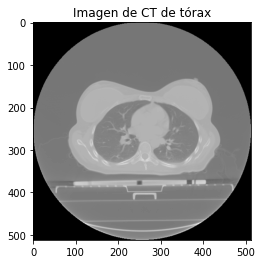

In [4]:
ruta_salida = 'imagenes/' # ruta donde se guardará la imagen
intercept = archivo_dicom.RescaleIntercept 
slope = archivo_dicom.RescaleSlope
if slope != 1:
    matriz_pixeles = slope * matriz_pixeles
matriz_pixeles += np.int16(intercept)

plt.imshow(matriz_pixeles, cmap=plt.cm.gray)
plt.savefig(ruta_salida +'CT_HU.png',bbox_inches='tight', pad_inches = 0)
plt.title('Imagen de CT de tórax')
plt.show()

### Corrección de píxeles

La gráfica anterior muestra un círculo con un tono mucho mas oscuro, esto es debido a que en esta zona se encuentra fuera del rango del tomógrafo y este lo lleno con valores arbitrarios. Para saber a que valores corresponde podemos observar su histograma.

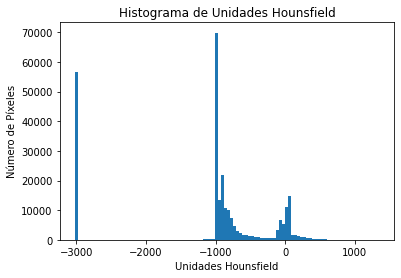

In [5]:
pixeles = np.concatenate((matriz_pixeles), axis=0)
plt.hist(pixeles, bins= 100)
plt.ylabel('Número de Píxeles')
plt.xlabel('Unidades Hounsfield')
plt.title('Histograma de Unidades Hounsfield')
plt.savefig(ruta_salida +'hist_HU.png',bbox_inches='tight')
plt.show()

El tomógrafo proporciona valores entre $-2000HU$ y $4000HU$, por lo que el valor cercano a $3000HU$ es el que corresponde al valor arbitrario, podemos imprimir este valor y saber a que elemento corresponde exactamente.

In [6]:
print('El valor arbitrario puesto por el tomógrafo es: ', min(pixeles), 'HU')

El valor arbitrario puesto por el tomógrafo es:  -3024 HU


Para corregir la imagen procedemos a eliminar este valor arbitrario y reemplazarlo por el correspondiente al aire que es de $-1024HU$. A continuación se presenta la imagen generada por matplotlib para los datos obtenidos.

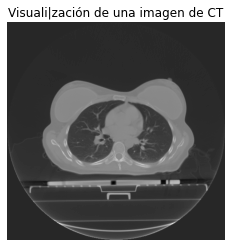

In [7]:
matriz_pixeles[matriz_pixeles == -3024] = -1024
plt.imshow(matriz_pixeles, cmap=plt.cm.gray)
plt.axis('off')
plt.savefig(ruta_salida +'CT_C1.png',bbox_inches='tight', pad_inches = 0)
plt.title('Visuali|zación de una imagen de CT')
plt.show()

In [8]:
print(f"Los rangos de Unidades Hounsfiedl de la imagen es: [{np.min(matriz_pixeles)}HU,{np.max(matriz_pixeles)}HU]")
print(f"La escala se extiende en: {abs(np.max(matriz_pixeles)-np.min(matriz_pixeles))} HU.")

Los rangos de Unidades Hounsfiedl de la imagen es: [-1460HU,1349HU]
La escala se extiende en: 2809 HU.


### Corte de mesa en las imágenes
Por motivos de visualización y para el posterior procesamiento de las imágenes es necesario eliminar cualquier elemento que no pertenezca a estructuras anatómicas, tal es el caso de la camilla. 
Para eso se visualizará todas las imagenes del examen.

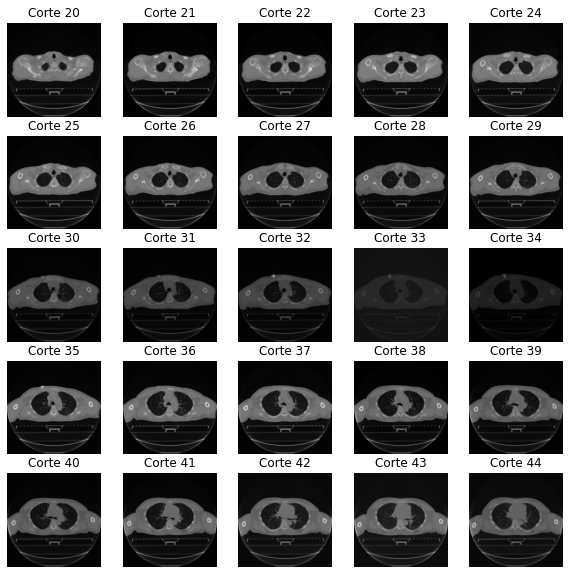

In [9]:
ruta_examen ='datos-torax-A/paciente6-A'
def sample_stack(stack, rows=5, cols=5, start_with=10, show_every=1):
    """Funcion que grafica las imágenes a partir de una matriz de 3 dimensiones"""
    fig,ax = plt.subplots(rows,cols,figsize=[10,10])
    for i in range(rows*cols):
        ind = start_with + i*show_every
        ax[int(i/rows),int(i % rows)].set_title('Corte %d' % ind)
        ax[int(i/rows),int(i % rows)].imshow(stack[ind],cmap=plt.cm.gray)
        ax[int(i/rows),int(i % rows)].axis('off')
    plt.show()

    
examen = imp.extrac_matrix(imp.load_scan(ruta_examen)) 
sample_stack(examen, rows=5, cols=5, start_with=20, show_every=1)

Se puede observar que en todas las imágenes la camilla se encuentra en una posición en específico, para verificar la posición se procederá a tomar solamente una de las imágenes y a recortar la sección correspondiente a la camilla 

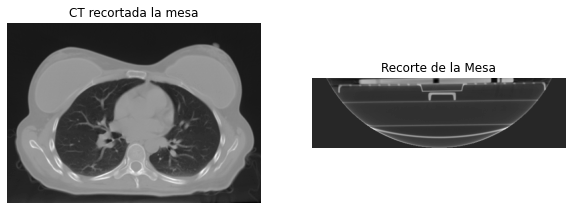

In [13]:
fig, ([ax1, ax2]) = plt.subplots(1,2, figsize=(10,5))
ax1.imshow(matriz_pixeles[100:370,70:450], cmap=plt.cm.gray)
ax1.set_title('CT recortada la mesa')
ax1.axis('off')
plt.imshow(matriz_pixeles[370:512,:],cmap=plt.cm.gray)
ax2.set_title('Recorte de la Mesa')
ax2.axis('off')
plt.show()

Se encontro que los píxeles que se encuentran fuera del rango del [x --> 0:370], los píxeles que no corresponden a estos rangos pertenecen a la camilla por lo que en esta zona se le asignará las unidades hounsfield correspondientes a el aire que es de -1024.
    

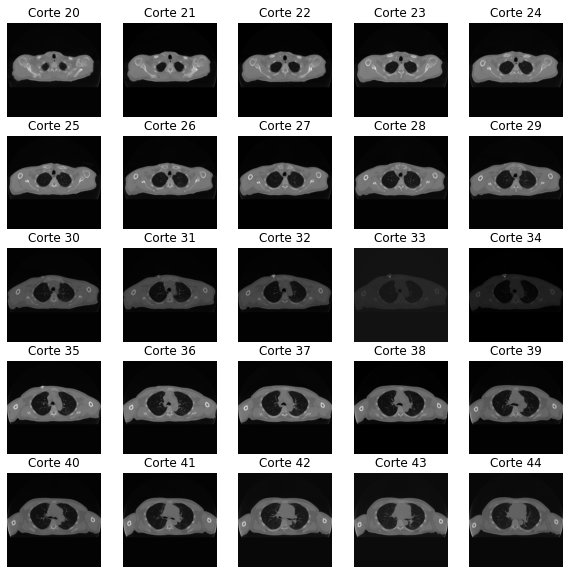

In [11]:
rm_matriz_pixeles = imp.remov_cama(examen)
rm_matriz_pixeles[370:512,:] = -1024
sample_stack(rm_matriz_pixeles, rows=5, cols=5, start_with=20, show_every=1)

Se puede observar que mediante esta modificación se ha eliminado la camilla y se le a reemplazado por aire.

### Visualización de una imagen de TC
La escala Hounsfield se extiende a largo de 2809 unidades, cuando se procede a realizar la visualización la biblioteca Matplotlib distribuirá la escala Hounsfield para que comprenda todos los valores que abarca la escala de grises, por lo que difícilmente es distinguible cada material dentro de la imagen,  ya que cada tonalidad de gris en la imagen comprende 11 unidades Hounsfield, lo que implica la pérdida de información al momento de la visualización y genera una imagen como la presentada anteriormente. Por lo que para una visualización adecuada se crearon las ventanas. Las ventanas permiten en definitiva extraer la información de la matriz de píxeles mostrando sólamente rangos específicos que comprendan los valores del órgano o tejido que se desee estudiar.

#### Visualización ventana [-100, 300]  HU 

Esta ventana es la que más se asemeja al estilo utilizado por el software iQ-LITE 3.0.0.

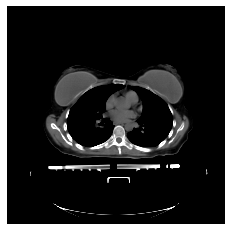

In [12]:
plt.imshow(matriz_pixeles, cmap=plt.cm.gray, vmin=-100, vmax=300)
plt.axis('off')
plt.show()

#### Visualización ventana [-1000, 1000]  HU 

Esta ventana  cubre los materiales aire, tejido blando y hueso.

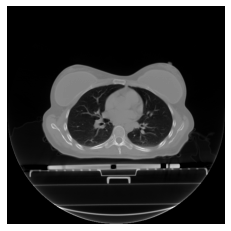

In [15]:
plt.imshow(matriz_pixeles, cmap=plt.cm.gray, vmin=-1000, vmax=1000)
plt.axis('off')
plt.savefig(ruta_salida +'CT_1000.png',bbox_inches='tight', pad_inches = 0)
plt.show()

#### Visualización ventana [200, 500]  HU 

Esta ventana muestra el hueso cortical.

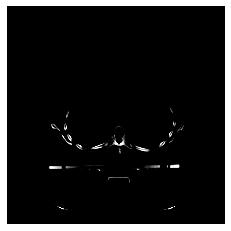

In [17]:
plt.imshow(matriz_pixeles, cmap=plt.cm.gray, vmin=200, vmax=500)
plt.axis('off')
plt.savefig(ruta_salida +'CT_500.png',bbox_inches='tight', pad_inches = 0)
plt.show()

## Visualización de un examen completo de CT


Para la visualización de las imágenes de TC en diferentes planos anatómicos se implementaron los 4 primeros pasos que se realizaron para el proceso de visualización de una sola imagen, con la diferencia de que para este caso el desarrollo es iterativo y debe ser aplicado para todos y cada uno de los archivos DICOM que pertenecen a la misma serie, por lo que la obtención, transformación y corrección de la matriz de píxeles es llevada a cabo para cada una de las imágenes de un mismo examen.
Luego se procede a generar la matriz de 3D que es guardada como un objeto `numpy.ndarray`.

>**Nota**: Los procesos iterativos fueron implementados en funciones guardadas en el archivo imprimir_imagen y son importada a este notebook como `ipm`.

In [27]:
ruta = 'datos-torax-A/paciente3-A'
imagen = imp.extrac_matrix(imp.load_scan(ruta)) # cargamos las imágenes 
imagen =  imp.remov_cama(imagen) # funcion que remueve la camilla
print(f"La matriz es del tipo de dato {type(imagen)} de la biblioteca numpy de dimensión {imagen.shape}.")

La matriz es del tipo de dato <class 'numpy.ndarray'> de la biblioteca numpy de dimensión (63, 512, 512).


### Escalamiento de Ejes

Este paso permite mostrar la imagen de acuerdo a las distancias físicas reales. Se utilizan diferentes atributos de los archivos DICOM, para más información puede visitar el siguiente link [<a href="http://dicom.nema.org/medical/dicom/current/output/chtml/part03/sect_C.7.6.2.html">1,</a> <a href="http://dicom.nema.org/dicom/2013/output/chtml/part03/sect_10.7.html">2,</a>] donde se describe de una manera más detallada el significado y tags de los atributos. A continuación se muestra un esquemático con el significado de algunos de los atributos que se utilizaran.
<img src="imagenes/space_p.png">

- **Pixel Spacing:** es una lista de 2 valores [Row Spacing, Column Spacing], que especifica la distancia física entre los centros de cada pixel bidimensional de la imagen axial de TC (0028,0030).

- **Image Position Patient:** este atributo detalla los valores de coordenadas x, y, z de la esquina superior izquierda (centro del primer vóxel transmitido) de la imagen en mm (0020,0032).

In [ ]:
print('PixelSpacing = ', slices[0].PixelSpacing)
print('ImagePositionPatient = ', slices[0].ImagePositionPatient)
print('InstanceNumber = ', slices[0].InstanceNumber)